# GCC118 - Programação Matemática
## Universidade Federal de Lavras
### Problema 1
#### Aluno: Eduardo Cesar Cauduro Coelho
#### Matrícula: 202310175
#### Aluno: Felipe Geraldo de Oliveira
#### Matrícula: 202310174

*Gerando um grafo não-direcionado conexo*

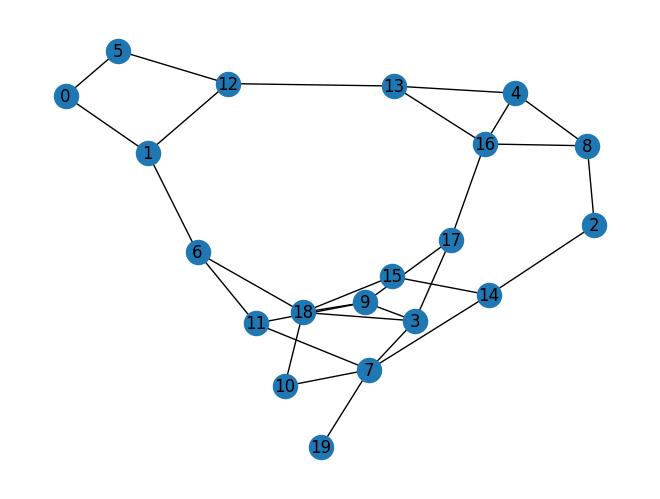

In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt

# n: numero de vertices
# m: numero de arestas
def gera_grafo_nao_direcionado_conexo(n, m):
    if(m < n - 1 or m > n * (n - 1) // 2):
      return None

    grafo = nx.Graph()
    vertices = list(range(n))
    grafo.add_nodes_from(vertices)
    random.shuffle(vertices)
    for i in range(n - 1):
        grafo.add_edge(vertices[i], vertices[i + 1])

    while grafo.number_of_edges() < m:
        u, v = random.sample(vertices, 2)
        if not grafo.has_edge(u, v):
            grafo.add_edge(u, v)

    return grafo

n = 20
m = 30
grafo = gera_grafo_nao_direcionado_conexo(n, m)

if(grafo != None):
  nx.draw(grafo, with_labels=True)
  plt.show()


## Instalação da biblioteca Gurobipy





In [2]:
!pip install gurobipy

## Recebe os parâmetros do grafo G(V, A), que são os vértices e as arestas:

In [3]:
vertices = grafo.nodes
arestas = grafo.edges

## Criação do modelo:

In [4]:
from gurobipy import Model, GRB, quicksum

modelo = Model("particao_grafo")

Restricted license - for non-production use only - expires 2026-11-23


## Declaração das variáveis de decisão $x_v, \forall v \in V$, binárias que indicam em qual partição cada vértice está:
* Se a variável possuir valor 0, o vértice está na partição A
* Se a variável possuir valor 1, o vértice está na partição B

In [5]:
var_vertices_particao = {}

for vertice in vertices:
  var_vertices_particao[vertice] = modelo.addVar(vtype=GRB.BINARY, name=f"vertice_{vertice}_particao")

## A partir disso, podemos concluir que, para cada aresta (i, j):
* Se os vértices i e j são da mesma partição, as variáveis $x_i$ e $x_j$ que representam as partições em que os vértices estão possuem o mesmo valor: 0 e 0 ou 1 e 1. Logo $x_i$ - $x_j$ (ou $x_j$ - $x_i$, nesse caso não importa a ordem) possui o valor 0.
* Se os vértices i e j são de partições diferentes, as variáveis $x_i$ e $x_j$ que representam as partições em que os vértices estão possuem valores diferentes: 0 e 1 ou 1 e 0. Logo, se $x_i$ - $x_j$ = 1, então $x_i$ - $x_j$ = -1, e vice versa.

## Considerando que queremos maximizar o número de arestas entre grafos, temos que somar a quantidade de arestas (i, j) tais que $x_i \neq x_j$. Como $x_i$ - $x_j$ = 1 ou -1, teríamos que somar o módulo dessa subtração |$x_i$ - $x_j$|.

## Dessa forma, teríamos o seguinte modelo:

\begin{equation}
\max f(x) = ∑\limits_{(i, j)\mid(i,j)\in A}|x_{i} - x_j|
\end{equation}

sujeito a:

\begin{alignat}{2}
x_{v} \in B && \qquad ∀v \in V
\end{alignat}

## Porém, a operação módulo |x| não é uma operação aceita em problemas de otimização linear e inteira, portanto precisamos linearizar a operação módulo.

## Para isso, declararemos, para cada aresta (i, j), as variáveis binárias $y_{ij}^+$ e $y_{ij}^-$, tal que: $$x_i - x_j = y_{ij}^+ - y_{ij}^-$$

## De modo que:

* caso $x_i - x_j = 0$, $y_{ij}^+ = 0$ e $y_{ij}^- = 0 \rightarrow y_{ij}^+ + y_{ij}^- = 0$
* caso $x_i - x_j = 1$, $y_{ij}^+ = 1$ e $y_{ij}^- = 0 \rightarrow y_{ij}^+ + y_{ij}^- = 1$
* caso $x_i - x_j = -1$, $y_{ij}^+ = 0$ e $y_{ij}^- = 1 \rightarrow y_{ij}^+ + y_{ij}^- = 1$

In [6]:
var_arestas_pos = {}
var_arestas_neg = {}

for aresta in arestas:
  var_arestas_pos[aresta] = modelo.addVar(vtype=GRB.BINARY, name=f"aresta_{aresta[0]}_{aresta[1]}_pos")
  var_arestas_neg[aresta] = modelo.addVar(vtype=GRB.BINARY, name=f"aresta_{aresta[0]}_{aresta[1]}_neg")

## Função objetivo: maximiza a quantidade de arestas que ligam vértices de partições distintas.

In [7]:
somatorio_arestas = quicksum(var_arestas_pos[aresta] + var_arestas_neg[aresta] for aresta in arestas)
modelo.setObjective(somatorio_arestas, GRB.MAXIMIZE)

## Restrições

* Como é um problema de maximização, temos a restrição: $$ y_{ij}^+ + y_{ij}^- \le 1 \quad \forall (i,j) \in A$$
Pois poderia ocorrer de ambas as variáveis possuirem valor 1, e sua subtração gerar o valor 0. Isso não pode ocorrer, pois se $ y_{ij}^+ + y_{ij}^- = 0$, queremos que ambas possuam o valor 0.

In [8]:
for aresta in arestas:
  modelo.addConstr(var_arestas_pos[aresta] + var_arestas_neg[aresta] <= 1)

* Representa a igualdade descrita anteriormente: $$x_i - x_j = y_{ij}^+ - y_{ij}^- \quad \forall (i,j) \in A$$


In [9]:
for aresta in arestas:
  modelo.addConstr((var_vertices_particao[aresta[0]] - var_vertices_particao[aresta[1]]) == var_arestas_pos[aresta] - var_arestas_neg[aresta])

## Logo, temos o seguinte modelo:

\begin{equation}
\max f(x, y) = ∑\limits_{(i, j)\mid(i,j)\in A}y_{ij}^+ + y_{ij}^-
\end{equation}

sujeito a:

\begin{alignat}{2}
y_{ij}^+ + y_{ij}^- \le 1 \quad \forall (i,j) \in A \\
x_i - x_j = y_{ij}^+ - y_{ij}^- \quad \forall (i,j) \in A \\
x_{v} \in B \qquad ∀v \in V \\
y_{ij} \in B \quad ∀(i,j) \in A
\end{alignat}

## Otimização do modelo:

In [10]:
modelo.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 60 rows, 80 columns and 180 nonzeros
Model fingerprint: 0x3946bc5d
Variable types: 0 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 2 rows and 3 columns
Presolve time: 0.00s
Presolved: 58 rows, 77 columns, 174 nonzeros
Found heuristic solution: objective 1.0000000
Variable types: 0 continuous, 77 integer (77 binary)

Root relaxation: objective 3.000000e+01, 29 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Be

## Impressão das soluções do modelo:

In [11]:
print(f"Valor ótimo: {modelo.objVal}")
for aresta in arestas:
  print(f"Aresta {aresta}: {var_arestas_neg[aresta].x + var_arestas_pos[aresta].x}")
for vertice in vertices:
  print(f"Vertice {vertice}: {var_vertices_particao[vertice].x}")

Valor ótimo: 26.0
Aresta (0, 1): 1.0
Aresta (0, 5): 1.0
Aresta (1, 6): 1.0
Aresta (1, 12): 1.0
Aresta (2, 8): 1.0
Aresta (2, 14): 1.0
Aresta (3, 18): 0.0
Aresta (3, 17): 0.0
Aresta (3, 9): 1.0
Aresta (3, 7): 1.0
Aresta (4, 16): 0.0
Aresta (4, 8): 1.0
Aresta (4, 13): 1.0
Aresta (5, 12): 1.0
Aresta (6, 11): 1.0
Aresta (6, 18): 1.0
Aresta (7, 19): 1.0
Aresta (7, 10): 0.0
Aresta (7, 11): 1.0
Aresta (7, 14): 1.0
Aresta (8, 16): 1.0
Aresta (9, 17): 1.0
Aresta (9, 11): 1.0
Aresta (9, 18): 1.0
Aresta (10, 18): 1.0
Aresta (12, 13): 1.0
Aresta (13, 16): 1.0
Aresta (14, 15): 1.0
Aresta (15, 18): 1.0
Aresta (16, 17): 1.0
Vertice 0: 1.0
Vertice 1: 0.0
Vertice 2: 1.0
Vertice 3: 0.0
Vertice 4: 1.0
Vertice 5: 0.0
Vertice 6: 1.0
Vertice 7: 1.0
Vertice 8: 0.0
Vertice 9: 1.0
Vertice 10: 1.0
Vertice 11: 0.0
Vertice 12: 1.0
Vertice 13: 0.0
Vertice 14: 0.0
Vertice 15: 1.0
Vertice 16: 1.0
Vertice 17: 0.0
Vertice 18: 0.0
Vertice 19: 0.0


## Grafo particionado gerado:
### Vértices de cores diferentes indicam partições diferentes (amarelo e verde).
### Arestas entre vértices de partições distintas são vermelhas e arestas entre vértices de mesma partição são azuis.

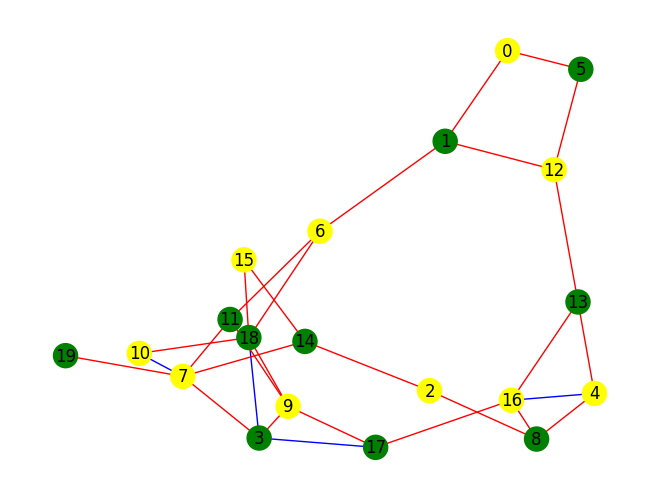

In [12]:
cor_vertices = []
for vertice in vertices:
    if var_vertices_particao[vertice].x:
        cor_vertices.append('yellow')
    else:
        cor_vertices.append('green')

cor_arestas = []
for origem, destino in arestas:
    if var_vertices_particao[origem].x != var_vertices_particao[destino].x:
        cor_arestas.append('red')
    else:
        cor_arestas.append('blue')

nx.draw(grafo, with_labels=True, node_color=cor_vertices, edge_color=cor_arestas)